<a name='0_0'></a>
# <span style="color:#ff5f27">👨🏻‍🏫 Forward Diffusion </span>

🗄️ Table of Contents:

- [📝 Imports](#0)
- [⚙️ Settings](#1)
- [👨🏻‍🏭 Preprocessing](#2)
- [🧖🏻‍♂️ Adding Noise ](#3)

<a name='0'></a>
## <span style="color:#ff5f27">📝 Imports </span>

In [1]:
import os
import requests
import torch
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
from skimage.transform import resize 
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize
from tools.diffusion import q_sample, create_diffusion_params

import warnings
warnings.filterwarnings('ignore')

/opt/anaconda3/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/anaconda3/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowExxb
  Referenced from: <AE5A0901-5B6C-3028-ADEE-0C068D0474D9> /opt/anaconda3/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <22270481-544D-33A2-9FD1-270293676910> /opt/anaconda3/lib/python3.9/site-packages/torch/lib/libc10.dylib
  warn(f"Failed to load image Python extension: {e}")


<a name='1'></a>
## <span style="color:#ff5f27">⚙️ Settings </span>

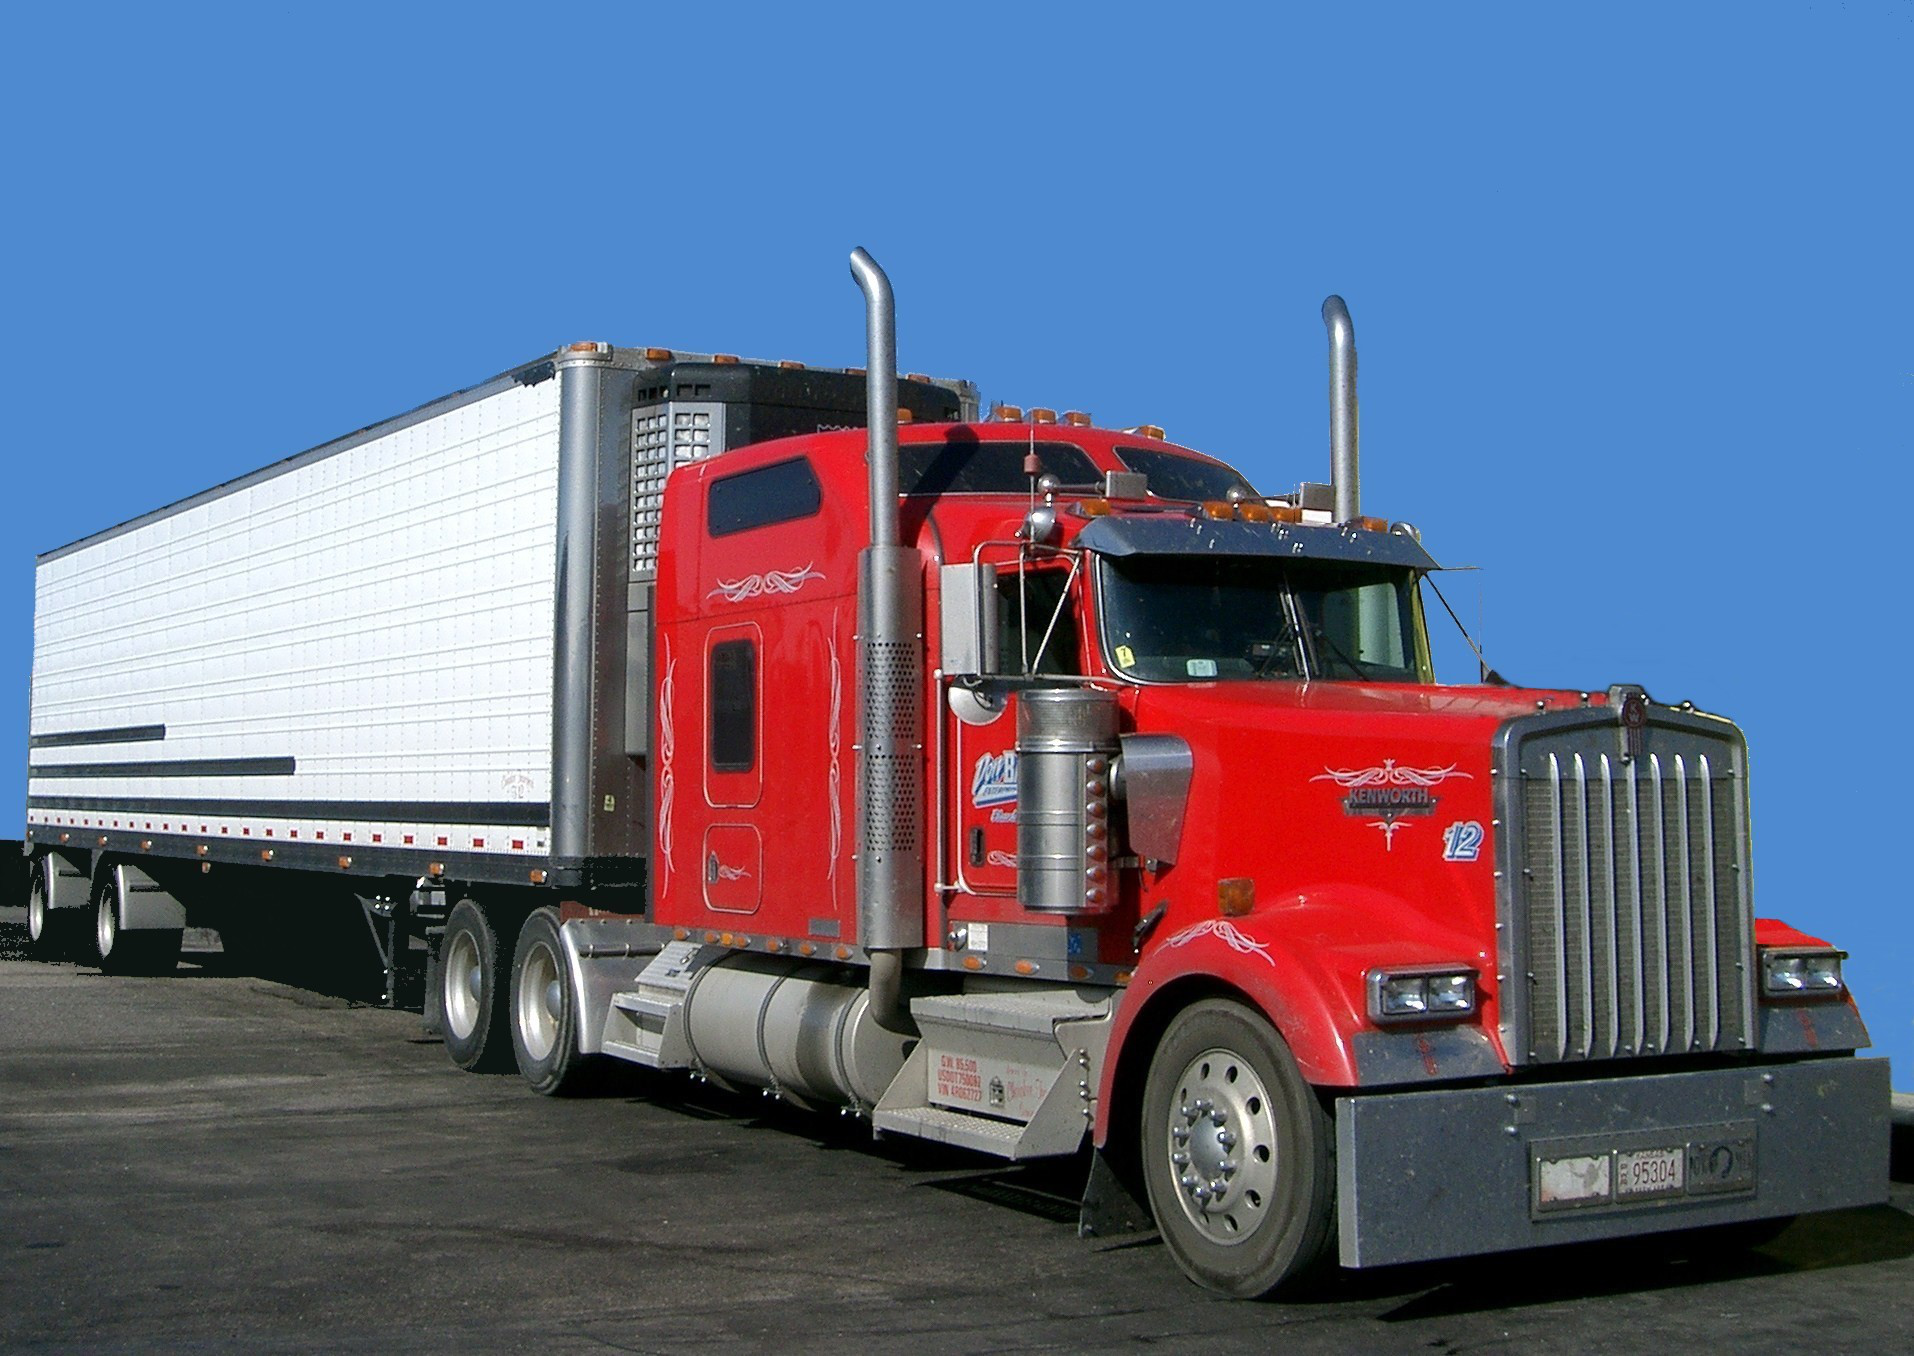

In [2]:
IMAGE_SIZE = 128

# Load image
url = 'https://upload.wikimedia.org/wikipedia/commons/8/85/Red_truck_USA.JPG'
image = Image.open(requests.get(url, stream=True).raw)
image

<a name='2'></a>
## <span style="color:#ff5f27">👨🏻‍🏭 Preprocessing </span>

In [3]:
transform = Compose([
    Resize(IMAGE_SIZE),
    CenterCrop(IMAGE_SIZE),
    ToTensor(),
    Lambda(lambda t: (t * 2) - 1),
    
])

# Reserve transformation from [-1, 1] to PIL image
reverse_transform = Compose([
     Lambda(lambda t: (t + 1) / 2),
     Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
     Lambda(lambda t: t * 255.),
     Lambda(lambda t: t.numpy().astype(np.uint8)),
     ToPILImage(),
])

In [4]:
# Check the shapes after transformation
x_start = transform(image).unsqueeze(0)
x_start.shape

torch.Size([1, 3, 128, 128])

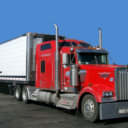

In [5]:
# Example after reserve transformation
reverse_transform(x_start.squeeze())

<a name='3'></a>
## <span style="color:#ff5f27">🧖🏻‍♂️ Adding Noise </span>

In [6]:
diffusion_parameters = create_diffusion_params(timesteps=200)

def get_noisy_image(x_start, t, diff_dict):
    """
    Returns the noisy image at time t.
    """
    # Sample noise
    x_noisy = q_sample(x_start, t=t, diff_dict=diff_dict)

    # turn back into PIL image
    noisy_image = reverse_transform(x_noisy.squeeze())

    return noisy_image

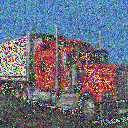

In [7]:
# Test for timestep t=40
t = torch.tensor([40])
get_noisy_image(x_start, t, diffusion_parameters)

In [8]:
# use seed for reproducability
torch.manual_seed(0)

def plot(imgs, with_orig=False, row_title=None, **imshow_kwargs):
    """
    Plots a list of images for various time steps.
    """
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(figsize=(200,200), nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [image] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

In [9]:
plot([
    get_noisy_image(x_start, torch.tensor([t]), diffusion_parameters) 
    for t 
    in [0, 50, 100, 150, 199]
])

---